# Approach: Embedding + MLP

In [1]:
import os
import pandas as pd
from sklearn.model_selection import KFold
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import csv


In [2]:
train = pd.read_csv("../../data/train.csv")
test = pd.read_csv("../../data/test.csv")

# IN KAGGLE:
#train = pd.read_csv("/kaggle/input/feedback-prize-english-language-learning/train.csv")
#test = pd.read_csv("/kaggle/input/feedback-prize-english-language-learning/test.csv")

### Generate Embeddings

In [3]:
from sentence_transformers import SentenceTransformer

sbert_model = SentenceTransformer("all-MiniLM-L6-v2")

# IN KAGGLE (UPLOAD sbert_model.zip TO NOTEBOOK AS DATASET FIRST):
#sbert_model = SentenceTransformer("/kaggle/input/sentence-bert")

embeddings = sbert_model.encode(train["full_text"].tolist(), show_progress_bar=True)

train["embedding"] = embeddings.tolist()


/root/projects/ai-lab/feedback-prize/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Batches: 100%|██████████| 123/123 [00:12<00:00,  9.71it/s]


### Define Dataset & Dataloader

In [4]:

class SBERTEmbeddingDataset(Dataset):
    def __init__(self, dataframe):
        self.embeddings = dataframe["embedding"].tolist()
        self.labels = dataframe[["cohesion", "syntax", "vocabulary", "phraseology", "grammar", "conventions"]].values.astype(float)

    def __len__(self):
        return len(self.embeddings)

    def __getitem__(self, idx):
        embedding = torch.tensor(self.embeddings[idx], dtype=torch.float)
        labels = torch.tensor(self.labels[idx], dtype=torch.float)
        return embedding, labels


In [5]:
dataset = SBERTEmbeddingDataset(train)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

### Define simple Feed Forward Net

In [6]:
def model_fn():
    return nn.Sequential(
        nn.Linear(384, 512),
        nn.ReLU(),
        nn.BatchNorm1d(512),
        nn.Dropout(0.4),

        nn.Linear(512, 256),
        nn.ReLU(),
        nn.BatchNorm1d(256),
        nn.Dropout(0.3),

        nn.Linear(256, 128),
        nn.ReLU(),
        nn.BatchNorm1d(128),
        nn.Dropout(0.2),

        nn.Linear(128, 6)  # Multi-Target Regression
    )


### Train Net

In [7]:
class MCRMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss(reduction='none')

    def forward(self, preds, targets):
        # preds/targets: [batch_size, num_targets]
        colwise_mse = self.mse(preds, targets).mean(dim=0)  # Mittelwert pro Spalte
        colwise_rmse = torch.sqrt(colwise_mse + 1e-8)       # RMSE pro Ziel
        return colwise_rmse.mean()                          # Mittelwert über Ziele


In [ ]:
import torch
from torch.utils.data import DataLoader
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

def cross_validate_kfold(
        dataset,
        model_fn,
        k: int = 5,
        num_epochs: int = 10,
        lr: float = 1e-3,
        batch_size: int = 32,
        weight_decay: float = 1e-2,
):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    kf = KFold(n_splits=k, shuffle=True, random_state=42)

    fold_final_val_losses = []      # letzter Val-Loss je Fold (für Statistik)
    fold_histories = []             # gesamte Loss-Historie je Fold

    plt.figure(figsize=(8, 5))

    for fold, (train_idx, val_idx) in enumerate(kf.split(dataset), start=1):
        print(f"\n─── Fold {fold} ───")

        train_subset = torch.utils.data.Subset(dataset, train_idx)
        val_subset   = torch.utils.data.Subset(dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
        val_loader   = DataLoader(val_subset,   batch_size=batch_size)

        model = model_fn().to(device)

        optimizer = torch.optim.AdamW(model.parameters(),
                                      lr=lr,
                                      weight_decay=weight_decay)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                               mode='min',
                                                               factor=0.5,
                                                               patience=2)

        loss_fn = torch.nn.MSELoss()          # oder dein eigenes Loss
        val_loss_history = []                 # log für diesen Fold

        for epoch in range(1, num_epochs + 1):
            # ----- Training -----
            model.train()
            for xb, yb in train_loader:
                xb, yb = xb.to(device), yb.to(device)
                preds = model(xb)

                loss = loss_fn(preds, yb)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            # ----- Validation -----
            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for xb, yb in val_loader:
                    xb, yb = xb.to(device), yb.to(device)
                    preds = model(xb)
                    val_loss += loss_fn(preds, yb).item() * xb.size(0)

            avg_val_loss = val_loss / len(val_loader.dataset)
            scheduler.step(avg_val_loss)
            val_loss_history.append(avg_val_loss)

            print(f"Fold {fold} | Epoch {epoch:>2}/{num_epochs} | "
                  f"val loss: {avg_val_loss:.4f}")

        # ----- Logging für Plot -----
        fold_histories.append(val_loss_history)
        fold_final_val_losses.append(val_loss_history[-1])

        plt.plot(range(1, num_epochs + 1),
                 val_loss_history,
                 label=f"Fold {fold}")

    # ----- Gesamter Plot -----
    plt.title("Validation-Loss je Fold")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(alpha=.3)
    plt.tight_layout()
    plt.show()

    mean_final = sum(fold_final_val_losses) / k
    print(f"\n⟹ Ø Validation-Loss über {k} Folds: {mean_final:.4f}")

    # gib ggf. zusätzlich die komplette Historie zurück
    return fold_final_val_losses, fold_histories, model



─── Fold 1 ───
Fold 1 | Epoch  1/25 | val loss: 9.7511
Fold 1 | Epoch  2/25 | val loss: 9.5157
Fold 1 | Epoch  3/25 | val loss: 9.3179
Fold 1 | Epoch  4/25 | val loss: 9.1485
Fold 1 | Epoch  5/25 | val loss: 8.6981
Fold 1 | Epoch  6/25 | val loss: 8.3325
Fold 1 | Epoch  7/25 | val loss: 7.6376
Fold 1 | Epoch  8/25 | val loss: 7.1340
Fold 1 | Epoch  9/25 | val loss: 6.2219
Fold 1 | Epoch 10/25 | val loss: 5.2584
Fold 1 | Epoch 11/25 | val loss: 4.4841
Fold 1 | Epoch 12/25 | val loss: 3.5461
Fold 1 | Epoch 13/25 | val loss: 2.8352
Fold 1 | Epoch 14/25 | val loss: 2.2297
Fold 1 | Epoch 15/25 | val loss: 1.6804
Fold 1 | Epoch 16/25 | val loss: 1.2638
Fold 1 | Epoch 17/25 | val loss: 1.0220
Fold 1 | Epoch 18/25 | val loss: 0.7822
Fold 1 | Epoch 19/25 | val loss: 0.6870
Fold 1 | Epoch 20/25 | val loss: 0.5487
Fold 1 | Epoch 21/25 | val loss: 0.5041
Fold 1 | Epoch 22/25 | val loss: 0.5085
Fold 1 | Epoch 23/25 | val loss: 0.4393
Fold 1 | Epoch 24/25 | val loss: 0.4269
Fold 1 | Epoch 25/25 | v

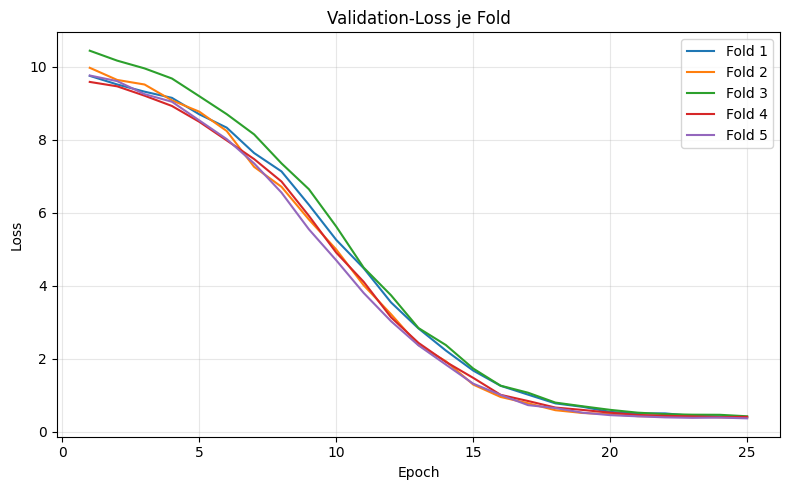


⟹ Ø Validation-Loss über 5 Folds: 0.4017


In [10]:
dataset = SBERTEmbeddingDataset(train)
fold_losses, fold_histories, model = cross_validate_kfold(
    dataset    = dataset,
    model_fn   = model_fn,
    k          = 5,
    num_epochs = 25,
    lr         = 1e-4,
    batch_size = 32,
)


### Generate Submission

In [150]:
embeddings = sbert_model.encode(test["full_text"].tolist(), show_progress_bar=True)

# Optional: Embeddings in die DataFrame schreiben
test["embedding"] = embeddings.tolist()

Batches: 100%|██████████| 1/1 [00:00<00:00, 29.18it/s]


In [151]:
class SBERTTestDataset(Dataset):
    def __init__(self, dataframe):
        self.ids = dataframe["text_id"].tolist()
        self.embeddings = dataframe["embedding"].tolist()

    def __len__(self):
        return len(self.embeddings)

    def __getitem__(self, idx):
        embedding = torch.tensor(self.embeddings[idx], dtype=torch.float)
        return self.ids[idx], embedding

In [152]:
test_dataset = SBERTTestDataset(test)
test_loader = DataLoader(test_dataset, batch_size=32)

In [153]:
model.eval()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

predictions = []
text_ids = []

with torch.no_grad():
    for ids, xb in test_loader:
        xb = xb.to(device)
        preds = model(xb)
        preds = preds.clamp(0, 5)
        preds = preds.cpu().numpy()
        predictions.extend(preds.tolist())
        text_ids.extend(ids)

submission_df = pd.DataFrame(predictions, columns=[
    "cohesion", "syntax", "vocabulary", "phraseology", "grammar", "conventions"
])
submission_df.insert(0, "text_id", text_ids)

submission_df.to_csv("submission.csv", index=False)